# Clustering

In [52]:
import pandas as pd
import numpy as np
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from config import *
from clustering_utils import *

## Load data

In [144]:
features_raw_new = pd.read_parquet(FEATURES_DIR / "all_features.pq")
features_raw_new.shape

(192, 520)

In [145]:
# Drop participants where all features are null
features = features_raw_new[~(features_raw_new.isna().sum(axis=1) == features_raw_new.shape[1]-2)]
features.shape

(171, 520)

In [146]:
y = pd.DataFrame(features["y"], columns=["y"])
X = features.drop(["participant_id", "y"], axis=1)
X.shape

(171, 518)

## Dimensionality Reduction

In [148]:
X_reduced = X.pipe(remove_low_variance_features).pipe(remove_multicollineraity, y).pipe(remove_outliers, 'MAD', 10.0)

/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
2025-05-09 14:44:49,303 - INFO - clustering_utils.remove_low_variance_features:50 - Kept 463 features out of 518
2025-05-09 14:44:50,716 - INFO - clustering_utils.remove_multicollineraity:108 - Removed 164 highly correlated features: {'FIXATIONS_avg_pupil_size_max_fix', 'EVIL_BASTARD_saccades_per_second_mean', 'EVIL_BASTARD_distance_to_fixpoint_mean', 'FIXATIONS_saccades_per_second_mean', 'EVIL_BASTARD_fixations_per_second_min', 'KING_DEVICK_wrong_direction_saccade_pct_max', 'FIXATIONS_distance_to_fixpoint_mean', 'KING_DEVICK_duration_mean_fix', 'REACTION_avg_pupil_size_mean_fix', 'REACTION_peak_velocity_mean_sacc', 'KING_DEVICK_wrong_direction_saccade_pct_min', 'KING_DEVICK_avg_pupil_size_median_fix', 'EVIL_BASTARD_tot

In [149]:
X_reduced.shape

(171, 299)

## Choose Clustering Method

In [6]:
import umap

/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [150]:
features_reduced = features[["participant_id", "y"] + list(X_reduced.columns)]

patients = features_reduced.query("y==1").drop(["participant_id", "y"], axis=1).dropna()
patients_std = pd.DataFrame(StandardScaler().fit_transform(patients), columns=patients.columns)


In [152]:
patients.shape

(55, 299)

In [153]:
umap_model = umap.UMAP(
    n_neighbors=15,         # smaller = more local focus, higher = more global
    min_dist=0.1,           # smaller = tighter clusters, higher = more spread
    n_components=2,         # use 2 for clustering/visualization (or 3)
    metric='manhattan',     # often better than 'euclidean' for clinical data
    random_state=42
)

/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


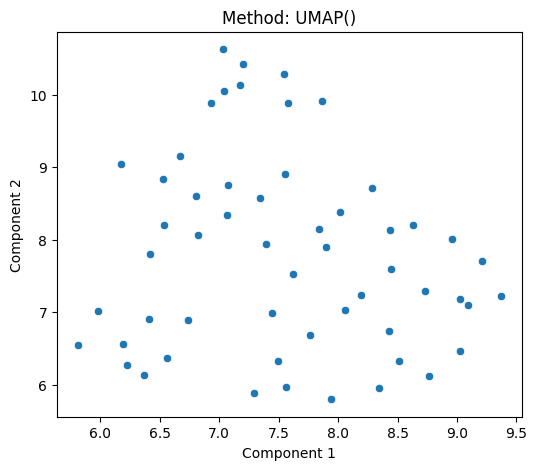

In [154]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
plot_scatter_dimensionality_reduction(patients_std, reducer=umap_model, arrows=False, ax=axs)

In [155]:
patients_transformed = umap_model.fit_transform(patients_std)

/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [156]:
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
import seaborn as sns

metric = "manhattan"

# Step 1: Apply UMAP
umap_model = umap.UMAP(
    n_neighbors=15,         # smaller = more local focus, higher = more global
    min_dist=0.1,           # smaller = tighter clusters, higher = more spread
    n_components=2,         # use 2 for clustering/visualization (or 3)
    metric=metric,     # often better than 'euclidean' for clinical data
    random_state=42
)

X_umap = umap_model.fit_transform(patients_std)  # X_filtered = ~100 preprocessed features

# Step 2: Run OPTICS
optics_model = OPTICS(
    min_samples=5,
    xi=0.05,              # sensitivity for cluster detection (lower = more sensitive)
    min_cluster_size=0.05, # fraction or count of minimum cluster size
    metric=metric     # must match UMAP if used for clustering
)

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(patients_std)

optics_model.fit(X_umap)
labels = optics_model.labels_  # -1 = noise

/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/idwe/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


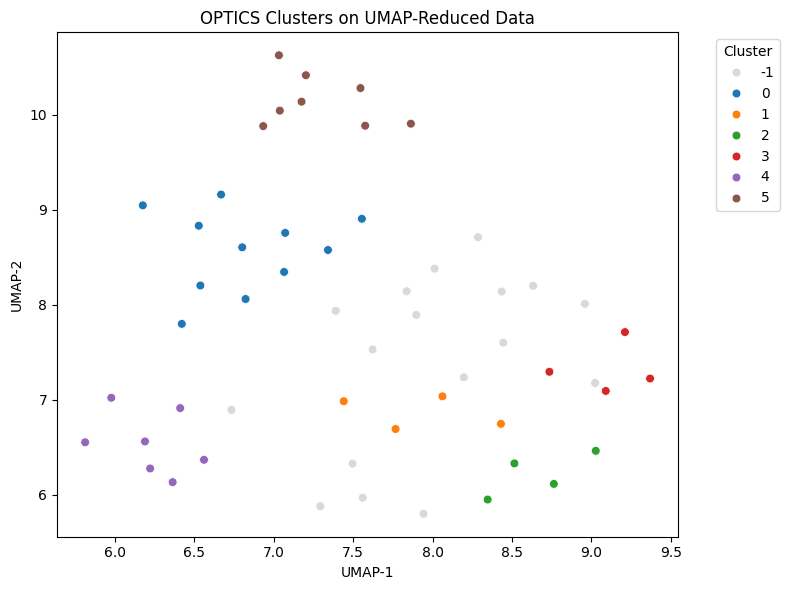

In [157]:
# Generate a color palette that matches the UMAP scatter plot
clusters = np.unique(labels[labels != -1])  # exclude noise for coloring
palette = sns.color_palette("tab10", n_colors=len(clusters))
label_color_map = {label: palette[i] for i, label in enumerate(clusters)}
label_color_map[-1] = (0.85, 0.85, 0.85)

# Visualize UMAP + Clusters
plt.figure(figsize=(8, 6))

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette=label_color_map, s=40)
plt.title("OPTICS Clusters on UMAP-Reduced Data")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

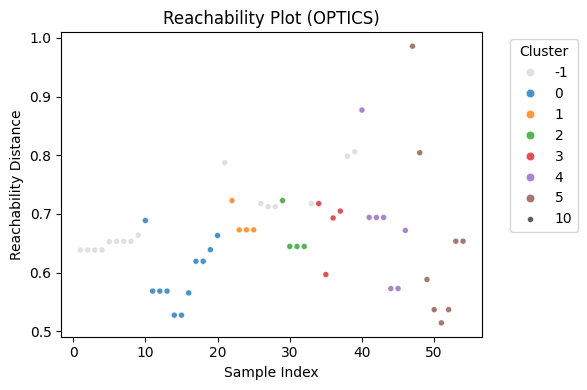

In [158]:
# Sort labels and reachability distances by OPTICS ordering
space = np.arange(len(optics_model.ordering_))
reachability = optics_model.reachability_[optics_model.ordering_]
labels = optics_model.labels_[optics_model.ordering_]

plt.figure(figsize=(6, 4))

sns.scatterplot(x=space, y=reachability, hue=labels, palette=label_color_map, size=10, alpha=0.8)

plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Sample Index')
plt.ylabel('Reachability Distance')
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()